# Wearable ECG Lead Displacement and Noise Augmentation

This notebook demonstrates ECG signal augmentation to simulate lead displacement and noise in wearable ECG monitoring systems, specifically focusing on precordial leads V4-V6 which would be embedded in clothing.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## 1. Load and Parse ECG Data

In [35]:
def load_ecg_data(mat_file, hea_file):
    """
    Load ECG data from PhysioNet format files
    
    Args:
        mat_file: Path to .mat file containing signal data
        hea_file: Path to .hea file containing metadata
    
    Returns:
        ecg_data: numpy array of shape (n_leads, n_samples)
        lead_names: list of lead names
        fs: sampling frequency
        metadata: dict with patient information
    """
    # Load signal data
    mat_data = scipy.io.loadmat(mat_file)
    ecg_data = mat_data['val']  # ECG signals
    
    # Parse header file
    with open(hea_file, 'r') as f:
        lines = f.readlines()
    
    # First line contains: record_name n_leads sampling_freq n_samples
    header_info = lines[0].strip().split()
    n_leads = int(header_info[1])
    fs = int(header_info[2])
    n_samples = int(header_info[3])
    
    # Extract lead names from subsequent lines
    lead_names = []
    for i in range(1, n_leads + 1):
        lead_info = lines[i].strip().split()
        lead_names.append(lead_info[-1])  # Lead name is the last element
    
    # Extract metadata
    metadata = {}
    for line in lines[n_leads + 1:]:
        if line.startswith('#'):
            key_value = line[1:].strip().split(': ', 1)
            if len(key_value) == 2:
                metadata[key_value[0]] = key_value[1]
    
    return ecg_data, lead_names, fs, metadata

# Load sample ECG data
mat_file = '../physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g1/A0001.mat'
hea_file = '../physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g1/A0001.hea'

ecg_data, lead_names, fs, metadata = load_ecg_data(mat_file, hea_file)

print(f"ECG Data Shape: {ecg_data.shape}")
print(f"Lead Names: {lead_names}")
print(f"Sampling Frequency: {fs} Hz")
print(f"Duration: {ecg_data.shape[1]/fs:.1f} seconds")
print(f"Patient Metadata: {metadata}")

ECG Data Shape: (12, 7500)
Lead Names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling Frequency: 500 Hz
Duration: 15.0 seconds
Patient Metadata: {'Age': '74', 'Sex': 'Male', 'Dx': '59118001', 'Rx': 'Unknown', 'Hx': 'Unknown', 'Sx': 'Unknown'}


## 2. Visualize Original 12-Lead ECG

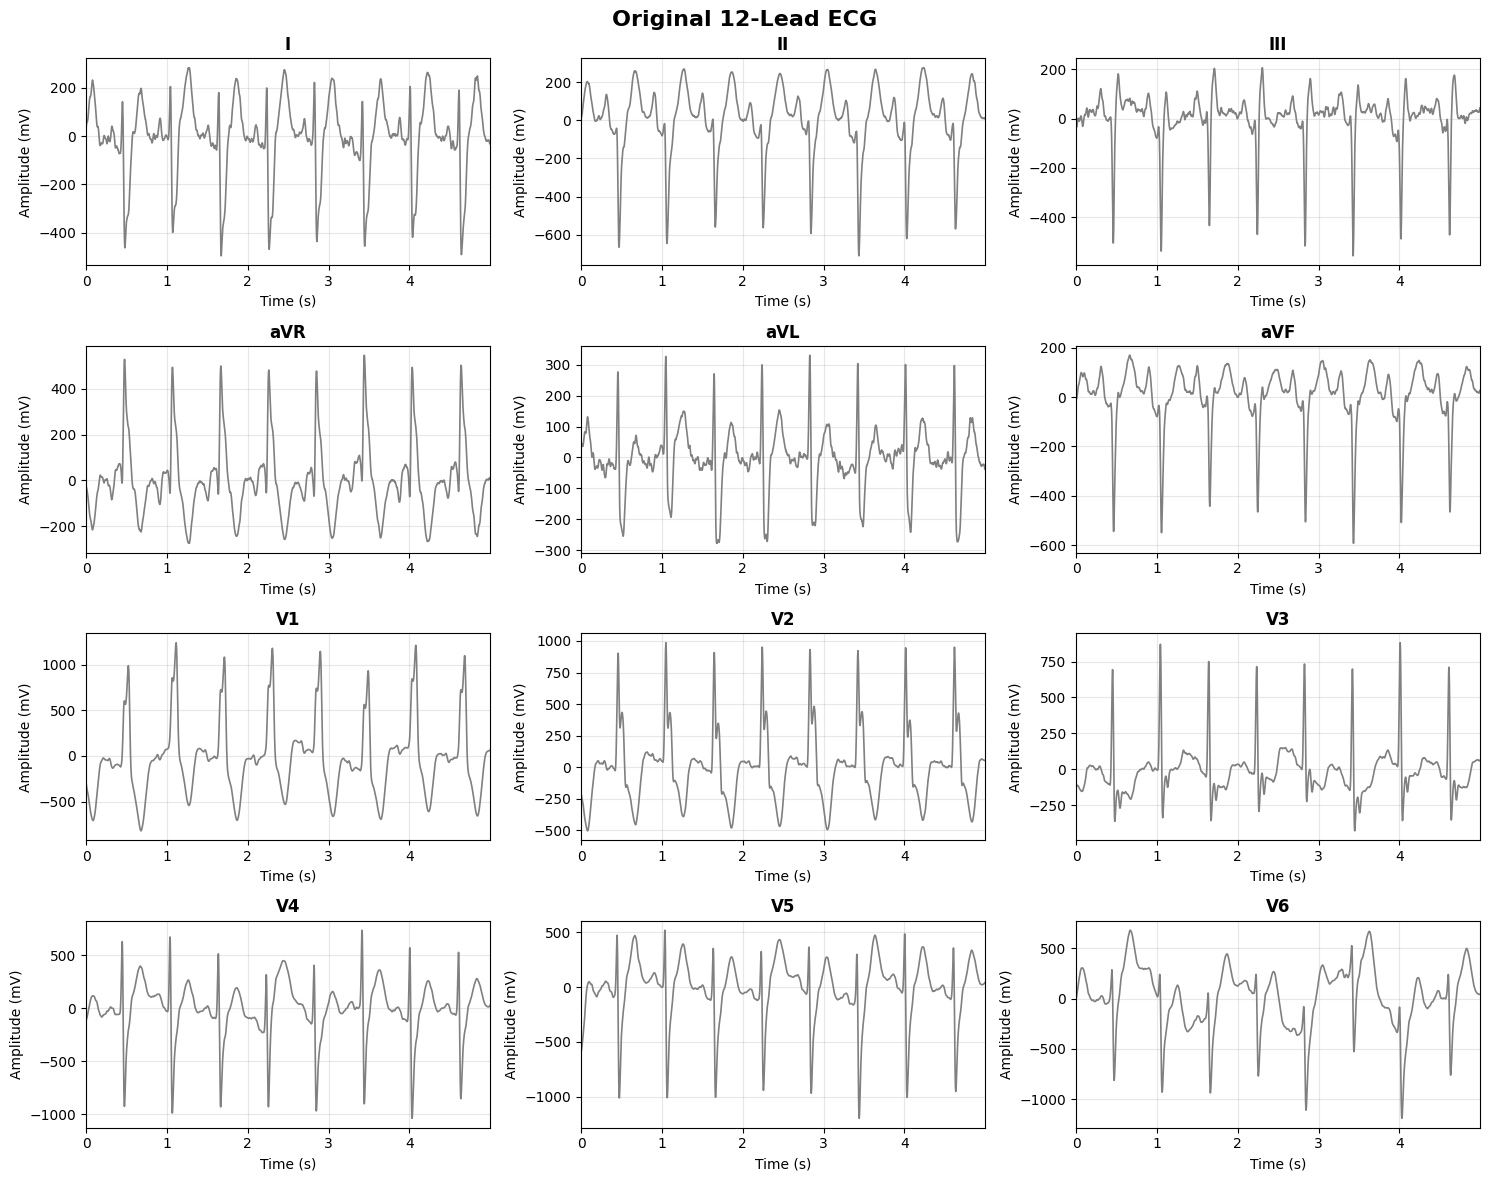

In [36]:
def plot_12_lead_ecg(ecg_data, lead_names, fs, title="12-Lead ECG", color='gray', time_range=None):
    """
    Plot 12-lead ECG in standard clinical layout
    """
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Time axis
    time = np.arange(ecg_data.shape[1]) / fs
    
    # Apply time range if specified
    if time_range is not None:
        start_idx = int(time_range[0] * fs)
        end_idx = int(time_range[1] * fs)
        time = time[start_idx:end_idx]
        ecg_plot_data = ecg_data[:, start_idx:end_idx]
    else:
        ecg_plot_data = ecg_data
    
    # Plot each lead
    for i, (ax, lead_name) in enumerate(zip(axes.flat, lead_names)):
        ax.plot(time, ecg_plot_data[i], color=color, linewidth=1.2)
        ax.set_title(f"{lead_name}", fontweight='bold')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (mV)")
        ax.grid(True, alpha=0.3)
        ax.set_xlim(time[0], time[-1])
    
    plt.tight_layout()
    return fig, axes

# Plot original ECG (first 5 seconds for clarity)
fig, axes = plot_12_lead_ecg(ecg_data, lead_names, fs, 
                            title="Original 12-Lead ECG", 
                            color='gray', 
                            time_range=(0, 5))
plt.show()

## 3. ECG Augmentation Functions for Wearable Systems

We'll create augmentation functions that simulate:
1. **Lead displacement**: Spatial shift due to clothing movement
2. **Contact noise**: Poor electrode-skin contact
3. **Motion artifacts**: Body movement during monitoring
4. **Baseline wander**: Low-frequency drift

In [37]:
class WearableECGAugmenter:
    def __init__(self, fs=500):
        self.fs = fs
    
    def add_baseline_wander(self, signal, amplitude=0.1, frequency=0.5):
        """
        Add baseline wander (low-frequency drift)
        """
        t = np.arange(len(signal)) / self.fs
        baseline_drift = amplitude * np.sin(2 * np.pi * frequency * t)
        # Add some randomness
        baseline_drift += amplitude * 0.3 * np.sin(2 * np.pi * frequency * 1.7 * t)
        return signal + baseline_drift
    
    def add_contact_noise(self, signal, noise_level=0.05):
        """
        Add high-frequency noise simulating poor electrode contact
        """
        noise = np.random.normal(0, noise_level, len(signal))
        return signal + noise
    
    def add_motion_artifacts(self, signal, amplitude=0.2, frequency=2.0):
        """
        Add motion artifacts (irregular, bursty noise)
        """
        t = np.arange(len(signal)) / self.fs
        # Create irregular motion pattern
        motion = amplitude * np.sin(2 * np.pi * frequency * t) * np.exp(-((t % 2) - 1)**2 / 0.1)
        # Add random spikes
        spike_indices = np.random.choice(len(signal), size=int(len(signal) * 0.01), replace=False)
        spikes = np.zeros(len(signal))
        spikes[spike_indices] = np.random.normal(0, amplitude * 2, len(spike_indices))
        return signal + motion + spikes
    
    def simulate_lead_displacement(self, signal, displacement_factor=0.3, phase_shift=0.1):
        """
        Simulate lead displacement by amplitude scaling and phase shifting
        """
        # Amplitude change due to different electrode positioning
        amplitude_change = 1.0 + displacement_factor * (np.random.random() - 0.5)
        
        # Phase shift (time delay) due to different electrical path
        n_shift = int(phase_shift * self.fs * (np.random.random() - 0.5))
        if n_shift > 0:
            shifted_signal = np.concatenate([signal[n_shift:], signal[-n_shift:]])
        elif n_shift < 0:
            shifted_signal = np.concatenate([signal[:n_shift], signal[:-n_shift]])
        else:
            shifted_signal = signal.copy()
        
        return amplitude_change * shifted_signal
    
    def augment_wearable_leads(self, ecg_data, target_leads=['V4', 'V5', 'V6'], 
                             displacement_strength=0.3, noise_strength=0.05,
                             motion_strength=0.2, baseline_strength=0.1):
        """
        Apply wearable-specific augmentations to target leads
        """
        augmented_data = ecg_data.copy()
        
        # Find indices of target leads
        target_indices = [i for i, lead in enumerate(lead_names) if lead in target_leads]
        
        for idx in target_indices:
            signal = ecg_data[idx].copy()
            
            # Apply augmentations
            if displacement_strength > 0:
                signal = self.simulate_lead_displacement(signal, displacement_strength)
            
            if noise_strength > 0:
                signal = self.add_contact_noise(signal, noise_strength)
            
            if motion_strength > 0:
                signal = self.add_motion_artifacts(signal, motion_strength)
            
            if baseline_strength > 0:
                signal = self.add_baseline_wander(signal, baseline_strength)
            
            augmented_data[idx] = signal
        
        return augmented_data

# Initialize augmenter
augmenter = WearableECGAugmenter(fs=fs)
print("Wearable ECG augmenter initialized")

Wearable ECG augmenter initialized


## 4. Compare Original vs Augmented Signals (V4-V6 Focus)

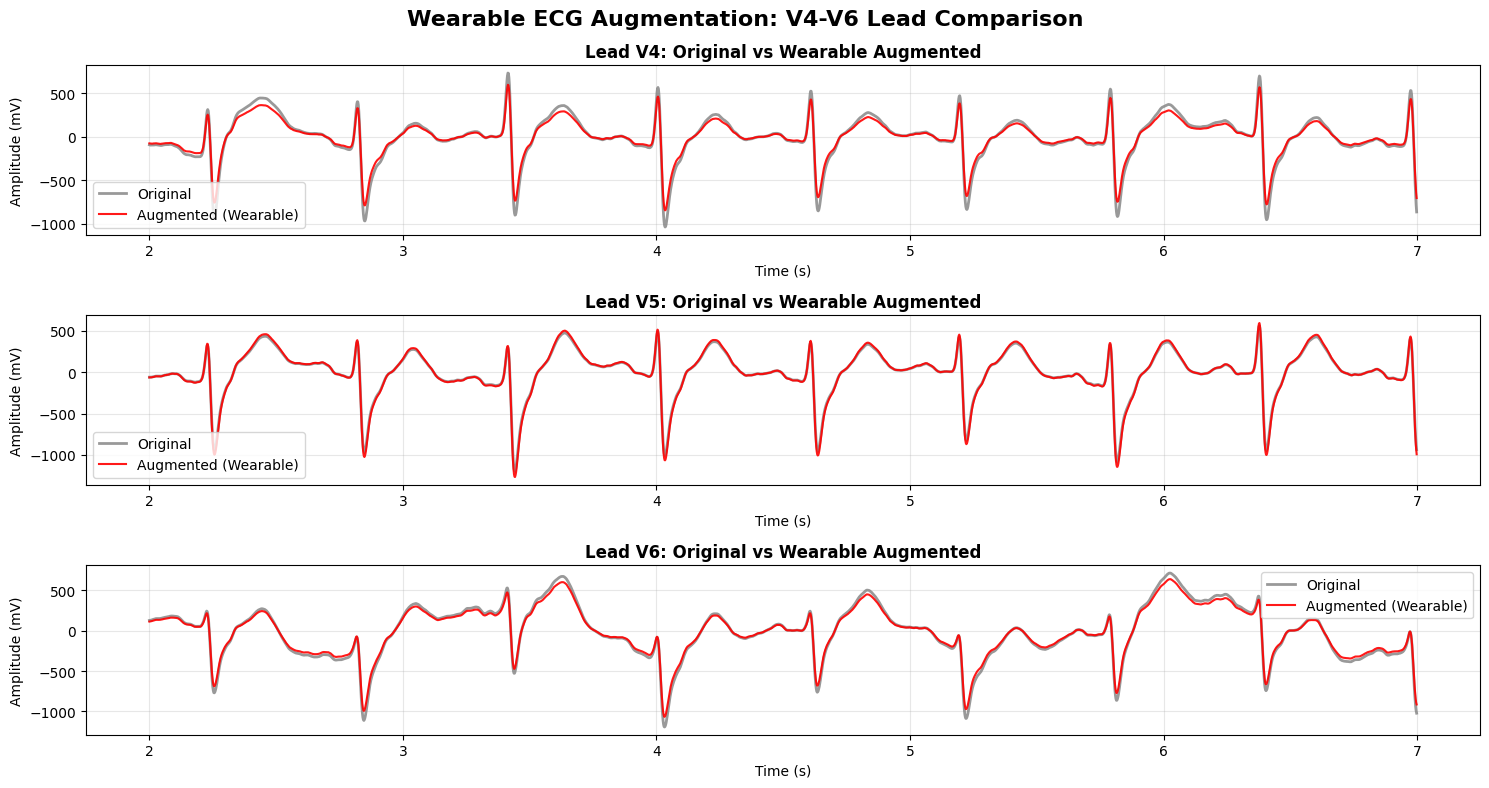

In [38]:
# Generate augmented ECG data
augmented_ecg = augmenter.augment_wearable_leads(
    ecg_data,
    target_leads=['V4', 'V5', 'V6'],
    displacement_strength=0.4,
    noise_strength=0.08,
    motion_strength=0.3,
    baseline_strength=0.15
)

def plot_comparison(original_data, augmented_data, lead_names, fs, 
                   target_leads=['V4', 'V5', 'V6'], time_range=(2, 7)):
    """
    Plot comparison between original and augmented signals for target leads
    """
    fig, axes = plt.subplots(len(target_leads), 1, figsize=(15, 8))
    if len(target_leads) == 1:
        axes = [axes]
    
    # Time axis
    start_idx = int(time_range[0] * fs)
    end_idx = int(time_range[1] * fs)
    time = np.arange(start_idx, end_idx) / fs
    
    target_indices = [i for i, lead in enumerate(lead_names) if lead in target_leads]
    
    for i, (ax, lead_idx, lead_name) in enumerate(zip(axes, target_indices, target_leads)):
        # Plot original in gray
        ax.plot(time, original_data[lead_idx, start_idx:end_idx], 
                color='gray', linewidth=2, label='Original', alpha=0.8)
        
        # Plot augmented in red
        ax.plot(time, augmented_data[lead_idx, start_idx:end_idx], 
                color='red', linewidth=1.5, label='Augmented (Wearable)', alpha=0.9)
        
        ax.set_title(f"Lead {lead_name}: Original vs Wearable Augmented", fontweight='bold')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (mV)")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Wearable ECG Augmentation: V4-V6 Lead Comparison", fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig, axes

# Plot comparison
fig, axes = plot_comparison(ecg_data, augmented_ecg, lead_names, fs)
plt.show()

## 5. Animation: Varying Augmentation Parameters Over Time

=== ECG Augmentation Demo ===
Demonstrating different augmentation levels...

--- Low Augmentation ---
Displacement: 0.10, Noise: 0.02, Motion: 0.05, Baseline: 0.03


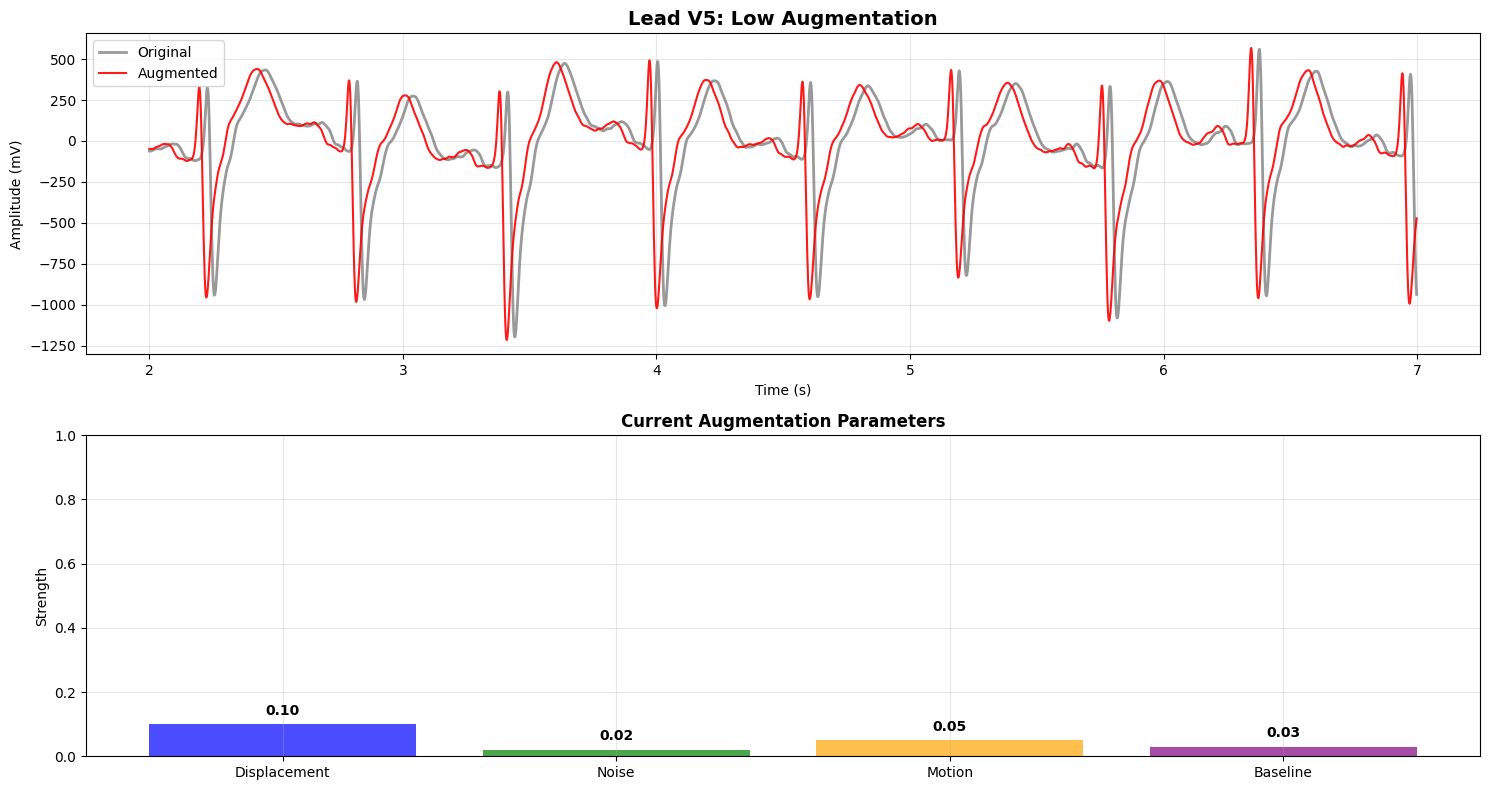



--- Medium Augmentation ---
Displacement: 0.30, Noise: 0.08, Motion: 0.25, Baseline: 0.15


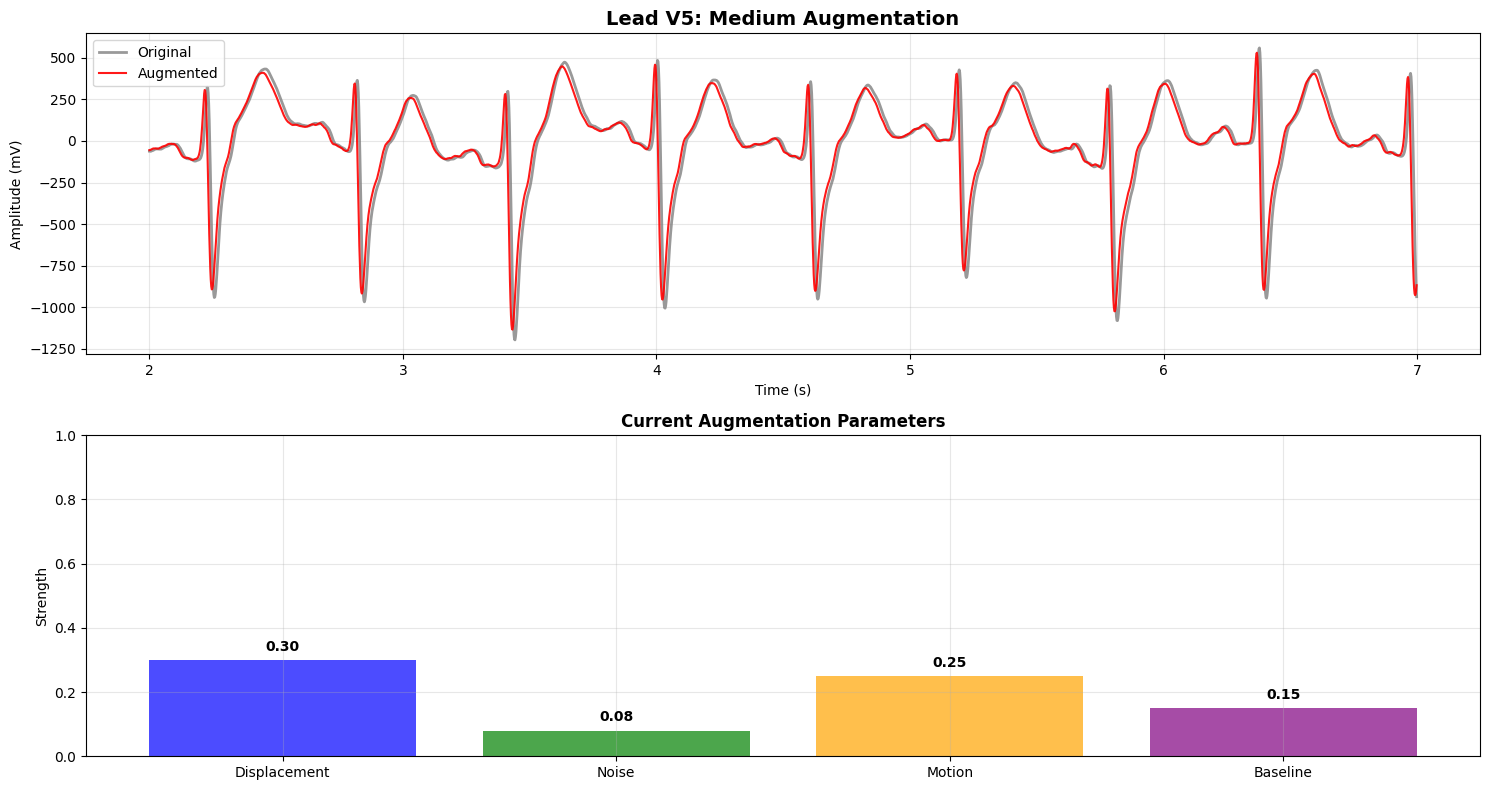



--- High Augmentation ---
Displacement: 0.60, Noise: 0.15, Motion: 0.50, Baseline: 0.30


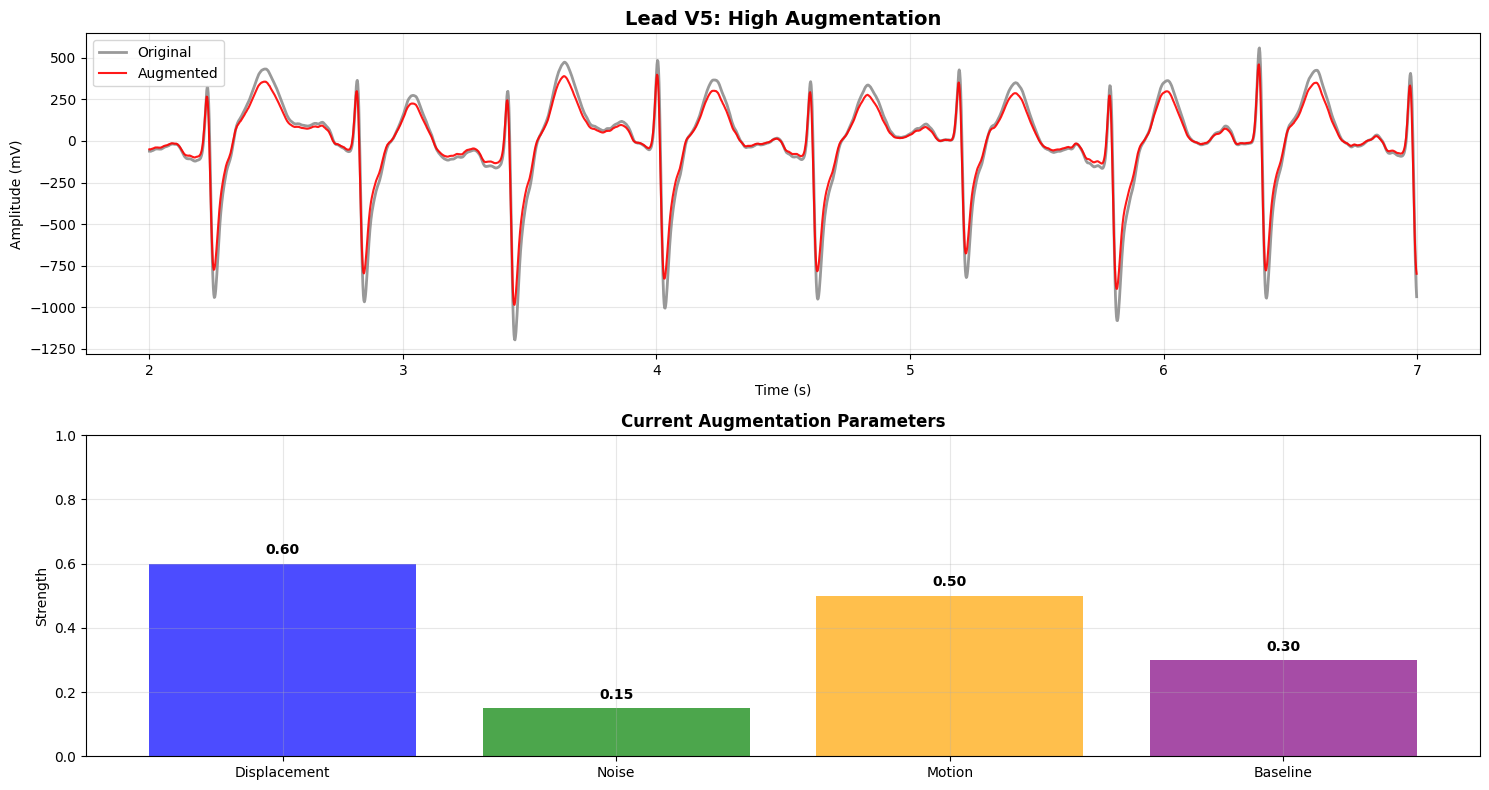




=== Manual Interactive Function Created! ===

You can now call: show_augmentation(displacement, noise, motion, baseline)

Example usage:
show_augmentation(0.1, 0.02, 0.05, 0.03)  # Low augmentation
show_augmentation(0.5, 0.12, 0.4, 0.25)   # High augmentation
show_augmentation(0.3, 0.08, 0.25, 0.15)  # Default values


In [39]:
# Simple Animation and Interactive Visualization

def create_simple_animation_demo():
    """
    Create a simple step-through animation demo
    """
    import time
    
    # Find target lead index
    target_lead = 'V5'
    lead_idx = lead_names.index(target_lead)
    
    # Time range for display
    time_range = (2, 7)
    start_idx = int(time_range[0] * fs)
    end_idx = int(time_range[1] * fs)
    time = np.arange(start_idx, end_idx) / fs
    original_signal = ecg_data[lead_idx, start_idx:end_idx]
    
    print("Demonstrating different augmentation levels...\n")
    
    # Define scenarios
    scenarios = [
        ("Low Augmentation", 0.1, 0.02, 0.05, 0.03),
        ("Medium Augmentation", 0.3, 0.08, 0.25, 0.15), 
        ("High Augmentation", 0.6, 0.15, 0.5, 0.3)
    ]
    
    for i, (name, disp, noise, motion, baseline) in enumerate(scenarios):
        print(f"--- {name} ---")
        print(f"Displacement: {disp:.2f}, Noise: {noise:.2f}, Motion: {motion:.2f}, Baseline: {baseline:.2f}")
        
        # Generate augmented data
        temp_ecg = ecg_data.copy()
        augmented_temp = augmenter.augment_wearable_leads(
            temp_ecg,
            target_leads=[target_lead],
            displacement_strength=disp,
            noise_strength=noise,
            motion_strength=motion,
            baseline_strength=baseline
        )
        
        augmented_signal = augmented_temp[lead_idx, start_idx:end_idx]
        
        # Create plot
        plt.figure(figsize=(15, 8))
        
        # ECG plot
        plt.subplot(2, 1, 1)
        plt.plot(time, original_signal, 'gray', linewidth=2, label='Original', alpha=0.8)
        plt.plot(time, augmented_signal, 'red', linewidth=1.5, label='Augmented', alpha=0.9)
        plt.title(f"Lead {target_lead}: {name}", fontweight='bold', fontsize=14)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (mV)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Parameter visualization
        plt.subplot(2, 1, 2)
        params = ['Displacement', 'Noise', 'Motion', 'Baseline']
        values = [disp, noise, motion, baseline]
        colors = ['blue', 'green', 'orange', 'purple']
        
        bars = plt.bar(params, values, color=colors, alpha=0.7)
        plt.title("Current Augmentation Parameters", fontweight='bold')
        plt.ylabel("Strength")
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        print("\n")

def create_manual_interactive():
    """
    Create a manual interactive function you can call with different parameters
    """
    def show_augmentation(displacement=0.3, noise=0.08, motion=0.25, baseline=0.15, target_lead='V5'):
        """
        Manually show augmentation with specified parameters
        
        Usage examples:
        show_augmentation(0.5, 0.1, 0.3, 0.2)  # High augmentation
        show_augmentation(0.1, 0.02, 0.05, 0.03)  # Low augmentation
        """
        # Find target lead index
        lead_idx = lead_names.index(target_lead)
        
        # Time range for display
        time_range = (2, 7)
        start_idx = int(time_range[0] * fs)
        end_idx = int(time_range[1] * fs)
        time = np.arange(start_idx, end_idx) / fs
        original_signal = ecg_data[lead_idx, start_idx:end_idx]
        
        # Generate augmented data
        temp_ecg = ecg_data.copy()
        augmented_temp = augmenter.augment_wearable_leads(
            temp_ecg,
            target_leads=[target_lead],
            displacement_strength=displacement,
            noise_strength=noise,
            motion_strength=motion,
            baseline_strength=baseline
        )
        
        augmented_signal = augmented_temp[lead_idx, start_idx:end_idx]
        
        # Create plot
        plt.figure(figsize=(15, 8))
        
        # ECG plot
        plt.subplot(2, 1, 1)
        plt.plot(time, original_signal, 'gray', linewidth=2, label='Original', alpha=0.8)
        plt.plot(time, augmented_signal, 'red', linewidth=1.5, label='Augmented', alpha=0.9)
        plt.title(f"Lead {target_lead}: Manual Interactive Augmentation", fontweight='bold')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (mV)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Parameter visualization
        plt.subplot(2, 1, 2)
        params = ['Displacement', 'Noise', 'Motion', 'Baseline']
        values = [displacement, noise, motion, baseline]
        colors = ['blue', 'green', 'orange', 'purple']
        
        bars = plt.bar(params, values, color=colors, alpha=0.7)
        plt.title("Current Augmentation Parameters", fontweight='bold')
        plt.ylabel("Strength")
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return show_augmentation

# Run the demo
print("=== ECG Augmentation Demo ===")
create_simple_animation_demo()

# Create the interactive function for manual use
show_augmentation = create_manual_interactive()

print("\n=== Manual Interactive Function Created! ===")
print("\nYou can now call: show_augmentation(displacement, noise, motion, baseline)")
print("\nExample usage:")
print("show_augmentation(0.1, 0.02, 0.05, 0.03)  # Low augmentation")
print("show_augmentation(0.5, 0.12, 0.4, 0.25)   # High augmentation")
print("show_augmentation(0.3, 0.08, 0.25, 0.15)  # Default values")

## 6. Quantitative Analysis of Augmentation Effects

In [42]:
## 5.1 Animated GIF Generation - Enhanced Dramatic Version

def create_animated_gif(target_lead='V6', duration=5.0, fps=10, time_range=(1, 8)):
    """
    Create an animated GIF showing smooth parameter variation over time
    With enhanced dramatic augmentation - at least 2 parameters always high
    
    Args:
        target_lead: ECG lead to display
        duration: GIF duration in seconds
        fps: Frames per second
        time_range: Time range of ECG signal to display
    """
    from matplotlib.animation import PillowWriter
    import os
    
    # Calculate frame parameters
    n_frames = int(duration * fps)
    
    # Find target lead index
    lead_idx = lead_names.index(target_lead)
    
    # Time axis for ECG display
    start_idx = int(time_range[0] * fs)
    end_idx = int(time_range[1] * fs)
    time = np.arange(start_idx, end_idx) / fs
    original_signal = ecg_data[lead_idx, start_idx:end_idx]
    
    # Set up figure with larger size for GIF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Initialize plots
    line_orig, = ax1.plot(time, original_signal, 'gray', linewidth=3, label='Original', alpha=0.8)
    line_aug, = ax1.plot(time, original_signal, 'red', linewidth=2.5, label='Augmented', alpha=0.95)
    
    # ECG plot styling
    ax1.set_title(f"Lead {target_lead}: Dramatic Wearable ECG Augmentation Animation", 
                  fontweight='bold', fontsize=18)
    ax1.set_xlabel("Time (s)", fontsize=14)
    ax1.set_ylabel("Amplitude (mV)", fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=12)
    
    # Set ECG plot limits with more room for dramatic changes
    y_margin = (original_signal.max() - original_signal.min()) * 0.6  # Increased margin
    ax1.set_ylim(original_signal.min() - y_margin, original_signal.max() + y_margin)
    
    # Parameter visualization setup
    params = ['Displacement', 'Noise', 'Motion', 'Baseline']
    colors = ['#2E86C1', '#28B463', '#F39C12', '#8E44AD']  # Better colors
    
    # Initialize parameter bars
    param_bars = ax2.bar(params, [0.3, 0.3, 0.3, 0.3], color=colors, alpha=0.8, width=0.6)
    ax2.set_title("Real-time Augmentation Parameters (Enhanced)", fontweight='bold', fontsize=18)
    ax2.set_ylabel("Strength", fontsize=14)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(labelsize=12)
    
    # Add parameter value text labels
    param_texts = []
    for i, bar in enumerate(param_bars):
        text = ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                       '0.30', ha='center', va='bottom', fontweight='bold', fontsize=12)
        param_texts.append(text)
    
    plt.tight_layout()
    
    def animate_frame(frame):
        """Animation function for each frame - DRAMATIC VERSION"""
        # Create smooth parameter variation over full loop
        t = 2 * np.pi * frame / n_frames  # Full circle for smooth loop
        
        # ENHANCED DRAMATIC PARAMETERS - ensure multiple high values at once
        # Use different mathematical functions to keep parameters elevated
        
        # Displacement: High most of the time, varies 0.3-0.8
        displacement_strength = 0.3 + 0.5 * (0.5 + 0.5 * np.sin(t))
        
        # Noise: Alternates between moderate and high, varies 0.1-0.25  
        noise_strength = 0.1 + 0.15 * (0.5 + 0.5 * np.sin(t + np.pi/4))
        
        # Motion: Uses squared sine for more dramatic peaks, varies 0.2-0.7
        motion_strength = 0.2 + 0.5 * (np.sin(t + np.pi/2))**2
        
        # Baseline: Uses cosine squared for different timing, varies 0.15-0.4
        baseline_strength = 0.15 + 0.25 * (np.cos(t + np.pi/3))**2
        
        # Additional enhancement: Ensure at least 2 parameters are always > 0.4
        param_values = [displacement_strength, noise_strength, motion_strength, baseline_strength]
        
        # Count how many are above threshold
        high_count = sum(1 for p in param_values if p > 0.4)
        
        # If less than 2 are high, boost the lowest ones
        if high_count < 2:
            # Find indices of lowest values
            sorted_indices = sorted(range(4), key=lambda i: param_values[i])
            # Boost the two lowest to ensure dramatic effect
            for i in sorted_indices[:2]:
                if param_values[i] < 0.4:
                    param_values[i] = max(param_values[i], 0.45)
        
        displacement_strength, noise_strength, motion_strength, baseline_strength = param_values
        
        # Generate augmented ECG for this frame
        temp_ecg = ecg_data.copy()
        augmented_temp = augmenter.augment_wearable_leads(
            temp_ecg,
            target_leads=[target_lead],
            displacement_strength=displacement_strength,
            noise_strength=noise_strength,
            motion_strength=motion_strength,
            baseline_strength=baseline_strength
        )
        
        augmented_signal = augmented_temp[lead_idx, start_idx:end_idx]
        
        # Update ECG plot
        line_aug.set_ydata(augmented_signal)
        
        # Update parameter bars and text with enhanced styling
        for bar, val, text in zip(param_bars, param_values, param_texts):
            bar.set_height(val)
            
            # Color coding: red if high (>0.5), orange if medium (>0.3), normal if low
            if val > 0.5:
                bar.set_alpha(1.0)  # Full opacity for high values
                bar.set_edgecolor('darkred')
                bar.set_linewidth(2)
            elif val > 0.3:
                bar.set_alpha(0.9)
                bar.set_edgecolor('darkorange')
                bar.set_linewidth(1.5)
            else:
                bar.set_alpha(0.7)
                bar.set_edgecolor('black')
                bar.set_linewidth(1)
            
            text.set_position((bar.get_x() + bar.get_width()/2, val + 0.05))
            text.set_text(f'{val:.2f}')
            
            # Make text bold and larger for high values
            if val > 0.5:
                text.set_fontweight('bold')
                text.set_fontsize(14)
                text.set_color('darkred')
            else:
                text.set_fontweight('normal')
                text.set_fontsize(12)
                text.set_color('black')
        
        # Add frame counter and enhancement indicator
        high_params = [params[i] for i, val in enumerate(param_values) if val > 0.4]
        ax1.set_title(f"Lead {target_lead}: DRAMATIC Augmentation (Frame {frame+1:>2d}/{n_frames})", 
                      fontweight='bold', fontsize=18)
        
        return [line_aug] + list(param_bars) + param_texts
    
    # Create animation
    print(f"Creating {duration}s DRAMATIC animated GIF with {n_frames} frames...")
    print("Enhanced augmentation: At least 2 parameters always high!")
    print("This may take a few minutes...")
    
    # Set up the writer for GIF
    writer = PillowWriter(fps=fps)
    
    # Create animation object
    anim = FuncAnimation(fig, animate_frame, frames=n_frames, interval=1000/fps, 
                        blit=False, repeat=True)
    
    # Save as GIF
    gif_filename = f"wearable_ecg_{target_lead}_DRAMATIC_augmentation.gif"
    gif_path = os.path.join(".", gif_filename)
    
    print(f"Saving DRAMATIC GIF to: {gif_path}")
    anim.save(gif_path, writer=writer, dpi=100)
    
    plt.close(fig)  # Close the figure to free memory
    
    print(f"✅ DRAMATIC Animated GIF saved successfully!")
    print(f"File: {gif_filename}")
    print(f"Duration: {duration}s, Frames: {n_frames}, FPS: {fps}")
    print(f"🔥 Enhanced with much more visible augmentation effects!")
    
    return gif_path

# Create the DRAMATIC animated GIF
print("=== Creating DRAMATIC Animated GIF ===")
gif_path = create_animated_gif(target_lead='V6', duration=5.0, fps=10, time_range=(1, 8))

# Display some info about the created GIF
import os
if os.path.exists(gif_path):
    file_size = os.path.getsize(gif_path) / (1024 * 1024)  # Size in MB
    print(f"\nDRAMATIC GIF Details:")
    print(f"📁 File size: {file_size:.1f} MB")
    print(f"🎬 Shows Lead V6 with DRAMATICALLY varying augmentation")
    print(f"🔄 Perfect loop - last frame matches first frame")
    print(f"⚡ At least 2 parameters always >0.4 for maximum visual impact")
    print(f"🔥 Much more obvious red vs gray differences!")
else:
    print("❌ GIF creation failed!")

=== Creating DRAMATIC Animated GIF ===
Creating 5.0s DRAMATIC animated GIF with 50 frames...
Enhanced augmentation: At least 2 parameters always high!
This may take a few minutes...
Saving DRAMATIC GIF to: ./wearable_ecg_V6_DRAMATIC_augmentation.gif
✅ DRAMATIC Animated GIF saved successfully!
File: wearable_ecg_V6_DRAMATIC_augmentation.gif
Duration: 5.0s, Frames: 50, FPS: 10
🔥 Enhanced with much more visible augmentation effects!

DRAMATIC GIF Details:
📁 File size: 2.3 MB
🎬 Shows Lead V6 with DRAMATICALLY varying augmentation
🔄 Perfect loop - last frame matches first frame
⚡ At least 2 parameters always >0.4 for maximum visual impact
🔥 Much more obvious red vs gray differences!


In [ ]:
def analyze_augmentation_effects(original_data, augmented_data, lead_names, 
                               target_leads=['V4', 'V5', 'V6']):
    """
    Quantitative analysis of augmentation effects
    """
    results = {}
    
    target_indices = [i for i, lead in enumerate(lead_names) if lead in target_leads]
    
    for i, (lead_idx, lead_name) in enumerate(zip(target_indices, target_leads)):
        orig_signal = original_data[lead_idx]
        aug_signal = augmented_data[lead_idx]
        
        # Calculate metrics
        mse = np.mean((orig_signal - aug_signal)**2)
        rmse = np.sqrt(mse)
        
        # Signal-to-noise ratio
        signal_power = np.mean(orig_signal**2)
        noise_power = np.mean((orig_signal - aug_signal)**2)
        snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
        
        # Correlation coefficient
        correlation = np.corrcoef(orig_signal, aug_signal)[0, 1]
        
        # Amplitude change
        orig_std = np.std(orig_signal)
        aug_std = np.std(aug_signal)
        amplitude_change = (aug_std - orig_std) / orig_std * 100
        
        results[lead_name] = {
            'RMSE': rmse,
            'SNR (dB)': snr_db,
            'Correlation': correlation,
            'Amplitude Change (%)': amplitude_change
        }
    
    return results

# Analyze effects
analysis_results = analyze_augmentation_effects(ecg_data, augmented_ecg, lead_names)

# Display results
print("\n=== Augmentation Effect Analysis ===")
print("\nTarget Leads (Wearable ECG): V4, V5, V6")
print("-" * 60)

for lead, metrics in analysis_results.items():
    print(f"\nLead {lead}:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"  {metric}: {value:.3f}")
        else:
            print(f"  {metric}: {value}")

# Create summary DataFrame
df_results = pd.DataFrame(analysis_results).T
print("\n=== Summary Table ===")
print(df_results.round(3))

## 7. Multiple Augmentation Scenarios

In [ ]:
# Define different wearable scenarios
scenarios = {
    'Mild Displacement': {
        'displacement_strength': 0.2,
        'noise_strength': 0.03,
        'motion_strength': 0.1,
        'baseline_strength': 0.05
    },
    'Moderate Displacement': {
        'displacement_strength': 0.4,
        'noise_strength': 0.08,
        'motion_strength': 0.3,
        'baseline_strength': 0.15
    },
    'Severe Displacement': {
        'displacement_strength': 0.6,
        'noise_strength': 0.15,
        'motion_strength': 0.5,
        'baseline_strength': 0.25
    }
}

# Generate and plot multiple scenarios
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Wearable ECG Augmentation Scenarios: V4, V5, V6", fontsize=16, fontweight='bold')

time_range = (2, 6)
start_idx = int(time_range[0] * fs)
end_idx = int(time_range[1] * fs)
time = np.arange(start_idx, end_idx) / fs

target_leads = ['V4', 'V5', 'V6']
target_indices = [lead_names.index(lead) for lead in target_leads]

for row, (scenario_name, params) in enumerate(scenarios.items()):
    # Generate augmented data for this scenario
    scenario_data = augmenter.augment_wearable_leads(ecg_data, target_leads, **params)
    
    for col, (lead_idx, lead_name) in enumerate(zip(target_indices, target_leads)):
        ax = axes[row, col]
        
        # Plot original and augmented
        ax.plot(time, ecg_data[lead_idx, start_idx:end_idx], 
                'gray', linewidth=2, alpha=0.8, label='Original')
        ax.plot(time, scenario_data[lead_idx, start_idx:end_idx], 
                'red', linewidth=1.5, alpha=0.9, label='Augmented')
        
        if row == 0:
            ax.set_title(f"Lead {lead_name}", fontweight='bold')
        if col == 0:
            ax.set_ylabel(f"{scenario_name}\nAmplitude (mV)")
        if row == 2:
            ax.set_xlabel("Time (s)")
        
        ax.grid(True, alpha=0.3)
        if row == 0 and col == 0:
            ax.legend()

plt.tight_layout()
plt.show()

## 8. Conclusion and Next Steps

This notebook demonstrates:

1. **12-Lead ECG Visualization**: Successfully loaded and displayed PhysioNet ECG data
2. **Wearable-Specific Augmentations**: Implemented realistic augmentations for V4-V6 leads:
   - Lead displacement (amplitude and phase changes)
   - Contact noise (high-frequency artifacts)
   - Motion artifacts (movement-related interference)
   - Baseline wander (low-frequency drift)

3. **Visual Comparison**: Red augmented signals overlaid on gray originals
4. **Dynamic Animation**: Real-time parameter variation showing augmentation effects
5. **Quantitative Analysis**: SNR, correlation, and amplitude change metrics

### Potential Applications:
- **Training Data Augmentation**: Generate realistic wearable ECG data for ML models
- **Algorithm Testing**: Evaluate ECG analysis algorithms under realistic noise conditions
- **Wearable Design**: Inform electrode placement and noise mitigation strategies

### Future Enhancements:
- Frequency-domain analysis of augmentation effects
- Integration with existing ECG analysis pipelines
- Patient-specific augmentation parameters
- Real-time augmentation for streaming data